In this notebook I explore how we can use a neural network to build and fit a library automatically.

In [1]:
# General imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

#Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Remainder imports
from os import listdir, path, getcwd

# Setting cuda
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Defining output folder
output_folder = getcwd()

# Defining inputs

As testdata, we use a analytic input features:

In [127]:
def c(x, t, D, a):
    c = 1 / np.sqrt(2*np.pi*(2*D*t + a**2))*np.exp(-x**2/(2*a**2+4*D*t))
    
    return c

def c_x(x, t, D, a):
    c_x = -x/(a**2+2*D*t) * c(x, t, D, a)
    return c_x


def c_xx(x, t, D, a):
    c_xx = -1/(a**2+2*D*t) * c(x, t, D, a) - x/(a**2+2*D*t) * c_x(x, t, D, a)
    return c_xx
    
def c_t(x, t, D, a):
    c_t = D * c_xx(x, t, D, a)
    
    return c_t

def theta_analytical(x_grid, t_grid, D, a):
    u = c(x_grid, t_grid, D, a).reshape(-1, 1) # Because numerical derivatives don't do at edge
    u2 = u**2

    u_x = c_x(x_grid, t_grid, D, a).reshape(-1, 1)
    u_xx = c_xx(x_grid, t_grid, D, a).reshape(-1, 1)

    u_t = c_t(x_grid, t_grid, D, a).reshape(-1, 1)
    
    theta_analytical = np.concatenate([np.ones_like(u), u, u**2, u_x, u_xx], axis=1)
    time_deriv_analytical = u_t
    
    return time_deriv_analytical, theta_analytical

Let's build a library with 2nd order polynomial, 2nd order derivative:

In [132]:
D = 0.5
a = 0.25

x = np.linspace(-5, 5, 500, dtype=np.float32)
t = np.linspace(0, 5, 100, dtype=np.float32)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
    
# Analytical
time_deriv, theta = theta_analytical(x_grid, t_grid, D, a)

In [133]:
theta[0].dtype

dtype('float32')

In [134]:
theta.shape

(50000, 5)

if we perform lstsquares we get:

In [24]:
np.linalg.lstsq(theta, time_deriv, rcond=None)[0]

array([[ 4.5972991e-17],
       [-4.5536491e-16],
       [-1.1071983e-16],
       [ 5.0000000e-01]], dtype=float32)

Which is the perfect answer :-)

# Simple network

Let's start by using a simple network to learn the weights; we simply feed the normal theta:

In [29]:
X_train = torch.tensor(theta, dtype=torch.float32)
y_train = torch.tensor(time_deriv, dtype=torch.float32)

In [30]:
model = nn.Sequential(*[nn.Linear(5, 1, bias=False)])

In [31]:
optimizer = torch.optim.Adam(model.parameters())
iterations = 10000

In [32]:
for it in np.arange(iterations):
    prediction = model(X_train)
    loss = torch.mean((prediction - y_train)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if it % 1000 == 0:
        print(loss.item())

0.17594009637832642
0.0024052285589277744
6.84987535350956e-05
1.9155568224960007e-05
9.16057251743041e-06
2.6868626719078748e-06
3.506295342958765e-07
1.1892629991905324e-08
4.2385130127886583e-11
9.458204517167907e-15


In [33]:
model[0].weight

Parameter containing:
tensor([[-1.6433e-09,  1.7092e-07, -6.7046e-07, -4.7474e-14,  5.0000e-01]],
       requires_grad=True)

Which is pretty close so that works :-)

In [34]:
np.linalg.lstsq(theta, time_deriv, rcond=None)[0]

array([[-3.46011828e-17],
       [ 5.43835810e-16],
       [-8.11850587e-16],
       [-2.69903132e-18],
       [ 5.00000000e-01]])

# Step 2: Normalizing theta

If we want to use a log-transform, we need to normalize theta between 0 and 1:

In [134]:
a = np.min(theta, axis=0) #numerical accuracy
b = np.max(theta, axis=0) - np.min(theta, axis=0)

a[0] = 0.0
b[0] = 1.0 # do not transform the constant column

In [135]:
theta_normalized = (theta - a) / b 

In [143]:
a_t = np.min(time_deriv, axis=0)
b_t = np.max(time_deriv, axis=0) - np.min(time_deriv, axis=0) 

time_deriv_normalized = (time_deriv - a_t ) / (b_t)

In [145]:
X_train = torch.tensor(theta_normalized, dtype=torch.float32)
y_train = torch.tensor(time_deriv_normalized, dtype=torch.float32)

In [160]:
model = nn.Sequential(*[nn.Linear(5, 1, bias=False)])
model[0].weight = nn.Parameter(torch.rand(model[0].weight.shape))

In [162]:
optimizer = torch.optim.Adam(model.parameters())
iterations = 10000

In [163]:
for it in np.arange(iterations):
    prediction = model(X_train)
    loss = torch.mean((prediction - y_train)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if it % 1000 == 0:
        print(loss.item())

0.47839516401290894
0.000341961596859619
0.00027726314147002995
0.00020647943892981857
0.00013973168097436428
9.538280573906377e-05
7.769828516757116e-05
7.293147064046934e-05
6.951551767997444e-05
6.481952004833147e-05


In [164]:
model[0].weight

Parameter containing:
tensor([[ 0.5338,  0.0825, -0.4727,  0.0178,  0.2134]], requires_grad=True)

In [165]:
np.linalg.lstsq(theta_normalized, time_deriv_normalized, rcond=None)[0].squeeze()


array([-4.8381045e-16, -2.2204460e-16,  7.3031858e-16,  1.6653345e-16,
        1.0000000e+00], dtype=float32)

So somehow its a lot harder to train the normalized theta?

So it's a lot harder to train... Weird. Let's check out a different normalization:

In [166]:
a = np.mean(theta, axis=0) #numerical accuracy
b = np.std(theta, axis=0)

a[0] = 0.0
b[0] = 1.0 # do not transform the constant column

In [171]:
theta_normalized = (theta - a) / b 


In [172]:
X_train = torch.tensor(theta_normalized, dtype=torch.float32)
y_train = torch.tensor(time_deriv, dtype=torch.float32)

In [173]:
model = nn.Sequential(*[nn.Linear(5, 1, bias=False)])

In [174]:
optimizer = torch.optim.Adam(model.parameters())
iterations = 10000

In [175]:
for it in np.arange(iterations):
    prediction = model(X_train)
    loss = torch.mean((prediction - y_train)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if it % 1000 == 0:
        print(loss.item())

0.2669551968574524
0.0008319122134707868
2.8883556524306186e-07
1.757089347067739e-13
1.229401661446668e-14
5.381115610611845e-15
1.41960445558775e-15
3.4110318541418134e-16
3.410790979147438e-16
2.8027790829052764e-16


In [176]:
model[0].weight

Parameter containing:
tensor([[-5.2047e-04,  5.0952e-09, -9.2259e-09,  3.3022e-15,  2.8208e-01]],
       requires_grad=True)

In [177]:
np.linalg.lstsq(theta_normalized, time_deriv, rcond=None)[0].squeeze()


array([-5.2046892e-04,  4.3055759e-09, -8.6046299e-09, -2.0071293e-17,
        2.8207895e-01], dtype=float32)

# Log space

In [126]:
a = np.min(theta, axis=0) - 1e-6#numerical accuracy
b = np.max(theta, axis=0) - np.min(theta, axis=0)

a[0] = 0.0
b[0] = 1.0 # do not transform the constant column

theta_normalized = (theta - a) / b 

In [127]:
theta_log = np.log(theta_normalized)

If we would fit using least squares, we'd get the followin result:

In [129]:
np.linalg.lstsq(theta_log, time_deriv, rcond=None)[0]

array([[ 0.        ],
       [ 0.01808725],
       [-0.02312976],
       [-0.51521766],
       [ 1.2450912 ]], dtype=float32)

In [130]:
X_train = torch.tensor(theta_log, dtype=torch.float32)
y_train = torch.tensor(time_deriv, dtype=torch.float32)

In [131]:
model = nn.Sequential(*[nn.Linear(5, 1, bias=False)])

In [132]:
optimizer = torch.optim.Adam(model.parameters())
iterations = 10000

In [133]:
for it in np.arange(iterations):
    prediction = model(X_train)
    loss = torch.mean((prediction - y_train)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if it % 1000 == 0:
        print(loss.item())

16.51873016357422
0.13111130893230438
0.0866071805357933
0.06916070729494095
0.06476349383592606
0.06175614148378372
0.05895283818244934
0.056992314755916595
0.05615696310997009
0.05599471554160118


So the problematic part is in the min/max normalization. We need it for the Linear layer though, so after we make the features we should rescale again:

# Scaling / Log / Rescaling

We need the min-max rescaling and log to get cross features, so we scale back theta after:

In [180]:
a = np.min(theta[:, 1:], axis=0) - 1e-6#numerical accuracy
b = np.max(theta[:, 1:], axis=0) - np.min(theta[:, 1:], axis=0)

theta_normalized = (theta[:, 1:] - a) / b 

In [181]:
theta_log = np.log(theta_normalized)

In [ ]:
a = np.min(theta[:, 1:], axis=0) - 1e-6#numerical accuracy
b = np.max(theta[:, 1:], axis=0) - np.min(theta[:, 1:], axis=0)

In [ ]:
class Linear(nn.Linear):
    '''Pytorch style linear layer which also calculates the derivatives w.r.t input. Has been written to be a thin wrapper around the pytorch layer. '''
    def __init__(self, in_features, out_features, a, b):
        super().__init__(in_features, out_features, bias=False)
        self.a = a
        self.b = b
        
    def forward(self, input):
        '''Calculates output'''
        z = F.linear(input, self.weight)
        result = torch.exp(z)
        return result


# Outer product layer

As in the old way, we can implement everything using an outer product:

In [155]:
class outer_product(nn.Module):
    '''Pytorch style linear layer which also calculates the derivatives w.r.t input. Has been written to be a thin wrapper around the pytorch layer. '''
    def __init__(self):
        super().__init__()
        self.tril_indices = torch.triu_indices(row=5, col=5, offset=1)
        
    def forward(self, input):
        '''Calculates output'''
        z = torch.matmul(input[:, :, None], input[:, None, :])[:, self.tril_indices[0], self.tril_indices[1]]#.reshape(input.shape[0], -1)
        
        #z_normed = z / torch.norm(z, dim=0)
        
        return z


In [268]:
a = np.mean(theta, axis=0) #numerical accuracy
b = np.std(theta, axis=0)

a[0] = 0.0
b[0] = 1.0 # do not transform the constant column

In [269]:
theta_normed = (theta - a) /b

In [270]:
theta_normed.shape

(50000, 5)

In [271]:
X_train = torch.tensor(theta_normed, dtype=torch.float32)
y_train = torch.tensor(time_deriv , dtype=torch.float32)

In [272]:
model = nn.Sequential(*[outer_product(), nn.Linear(10, 1, bias=True)])

In [273]:
optimizer = torch.optim.Adam(model.parameters())
iterations = 10000

In [274]:
for it in np.arange(iterations):
    prediction = model(X_train)
    loss = torch.mean((prediction - y_train)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if it % 1000 == 0:
        print(loss.item())

16.974159240722656
0.0483686700463295
0.012646198272705078
0.007338393479585648
0.0035581283736974
0.0010924830567091703
0.00017606733308639377
2.0091471014893614e-05
2.8423751246009488e-06
1.66701184411977e-07


In [275]:
model[1].weight

Parameter containing:
tensor([[ 1.4642e-04, -3.5886e-04, -4.5668e-10,  2.8206e-01,  4.5419e-05,
         -1.0931e-10,  1.6444e-06, -1.4913e-10,  6.6258e-06, -3.3704e-11]],
       requires_grad=True)

In [276]:
model[1].bias

Parameter containing:
tensor([-0.0006], requires_grad=True)

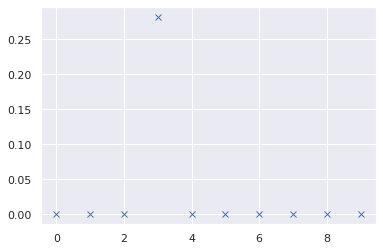

In [277]:
plt.plot(model[1].weight.detach().numpy().squeeze(), 'x')

In [278]:
model[0](X_train).shape

torch.Size([50000, 10])

In [285]:
model.zero_grad()

In [286]:
prediction = model(X_train)
loss = torch.mean((prediction - y_train)**2)
loss.backward()

In [287]:
model[1].weight.grad

tensor([[ 1.7713e-06, -6.3450e-06, -2.4461e-09, -3.3424e-07,  9.5131e-06,
         -1.4830e-08,  2.3276e-07, -2.4728e-08,  3.6570e-06,  6.2027e-11]])

How would that look like without the standardization:

In [244]:
X_train = torch.tensor(theta, dtype=torch.float32)
y_train = torch.tensor(time_deriv , dtype=torch.float32)

In [245]:
model = nn.Sequential(*[outer_product(), nn.Linear(10, 1, bias=True)])

In [246]:
optimizer = torch.optim.Adam(model.parameters())
iterations = 10000

In [247]:
for it in np.arange(iterations):
    prediction = model(X_train)
    loss = torch.mean((prediction - y_train)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if it % 1000 == 0:
        print(loss.item())

0.43380165100097656
0.00034165961551479995
4.4629498006543145e-05
2.2150792574393563e-05
1.529714063508436e-05
9.889851753541734e-06
5.752701326855458e-06
2.6801058083947282e-06
9.649442063164315e-07
3.724122734638513e-07


In [253]:
model[1].weight

Parameter containing:
tensor([[-1.2561e-02,  6.3200e-02, -5.0558e-06,  5.0039e-01, -6.5717e-02,
          2.7903e-05, -4.4397e-04, -2.3097e-05, -1.9441e-03, -4.7750e-07]],
       requires_grad=True)

In [254]:
model[1].bias

Parameter containing:
tensor([0.0003], requires_grad=True)

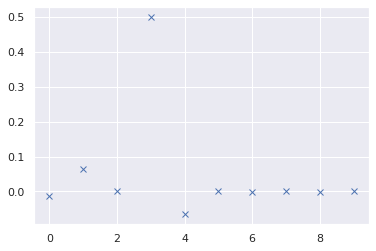

In [255]:
plt.plot(model[1].weight.detach().numpy().squeeze(), 'x')

In [256]:
prediction = model(X_train)
loss = torch.mean((prediction - y_train)**2)
loss.backward()

In [257]:
model[1].weight.grad

tensor([[-2.2028e-06,  8.3921e-06, -1.2907e-09, -1.0582e-06, -9.4064e-06,
          1.5103e-08,  5.8082e-06, -2.1975e-08, -8.3757e-06, -3.2276e-08]])

Now let's check it out with the norm:

In [258]:
theta_normed = theta / np.linalg.norm(theta, axis=0)

In [259]:
X_train = torch.tensor(theta_normed, dtype=torch.float32)
y_train = torch.tensor(time_deriv , dtype=torch.float32)

In [260]:
model = nn.Sequential(*[outer_product(), nn.Linear(10, 1, bias=True)])

In [261]:
optimizer = torch.optim.Adam(model.parameters())
iterations = 10000

In [262]:
for it in np.arange(iterations):
    prediction = model(X_train)
    loss = torch.mean((prediction - y_train)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if it % 1000 == 0:
        print(loss.item())

0.11555866152048111
0.07917913794517517
0.07881996780633926
0.07846277952194214
0.07810704410076141
0.07775254547595978
0.07739928364753723
0.07704717665910721
0.0766962468624115
0.07634644210338593


In [263]:
model[1].weight

Parameter containing:
tensor([[-10.3311,  -9.9170,   0.1281,  10.2887,  -9.7190,   0.0757,   9.9080,
          -0.0537,  10.2377,  -0.0164]], requires_grad=True)

In [264]:
model[1].bias

Parameter containing:
tensor([2.3428e-05], requires_grad=True)

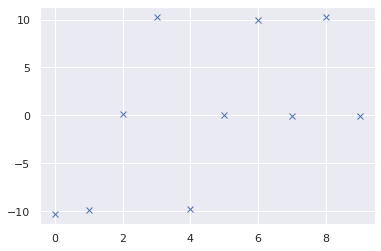

In [265]:
plt.plot(model[1].weight.detach().numpy().squeeze(), 'x')

In [266]:
prediction = model(X_train)
loss = torch.mean((prediction - y_train)**2)
loss.backward()

In [267]:
model[1].weight.grad

tensor([[ 6.4373e-06,  1.4868e-05,  1.2068e-10, -2.2053e-05,  1.2161e-04,
          1.6073e-10, -1.4671e-04, -9.8037e-11, -3.8687e-04, -2.6962e-11]])